# Sparse Hebbian Learning: toward a quantitative measure of the quality of filters

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 0
DEBUG_DOWNSCALE, verbose = 10, 10
DEBUG_DOWNSCALE, verbose = 1, 10

tag = 'independance'

homeo_methods = ['HAP', 'None']
alpha_homeo = 0.2

nb_quant = 128
nb_quant = 256
C = 5.
homeo_methods = ['HEH', 'None']
eta_homeo = 0.1
alpha_homeo = 0.0
#do_double_shuffle = True
#do_double_shuffle = False
#do_random = True

n_iter = 2**13 + 1

record_num_batches = 2**12
N_show = 120
max_patches = 10
seed = 42
np.random.seed(seed)

opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, n_iter=n_iter, 
            eta_homeo=eta_homeo, alpha_homeo=alpha_homeo, 
            C=C, nb_quant=nb_quant, P_cum=None, verbose=verbose)

from shl_scripts.shl_experiments import SHL
shl = SHL(**opts)
data = shl.get_data(matname=tag)

Extracting data..loading the data called : data_cache/independance_data
Data is of shape : (81920, 144) - done in 0.06s.


In [4]:
!ls -l {shl.data_cache}/{tag}*
!rm -fr {shl.data_cache}/{tag}*lock*

-rw-rw-r-- 1 laurent laurent 94371968 Feb 20 12:17 data_cache/independance_data.npy
-rw-rw-r-- 1 laurent laurent  2533678 Feb 20 15:12 data_cache/independance_HEH_dico.pkl
-rw-rw-r-- 1 laurent laurent  2533679 Feb 20 16:24 data_cache/independance_None_dico.pkl


In [5]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.mean(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (81920, 144)
average of patches =  1.274788766001906e-05  +/-  0.008208904871778732
average energy of data =  0.05934010035972646 +/- 0.06825018408240678


In [6]:
stick = np.arange(shl.n_dictionary)*nb_quant

indx = np.random.permutation(data.shape[0])[:record_num_batches]
P_cum_zeroeffect = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((shl.n_dictionary, 1))


## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

loading the dico called : data_cache/independance_HEH_dico.pkl
size of dictionary = (number of filters, size of imagelets) =  (529, 144)
average of filters =  0.0001661485290286474 +/- 0.008758877783279759
average energy of filters =  1.0 +/- 8.34676118839486e-17
loading the dico called : data_cache/independance_None_dico.pkl
size of dictionary = (number of filters, size of imagelets) =  (529, 144)
average of filters =  7.984518156512236e-05 +/- 0.008270111065454899
average energy of filters =  1.0 +/- 9.043487695512937e-17


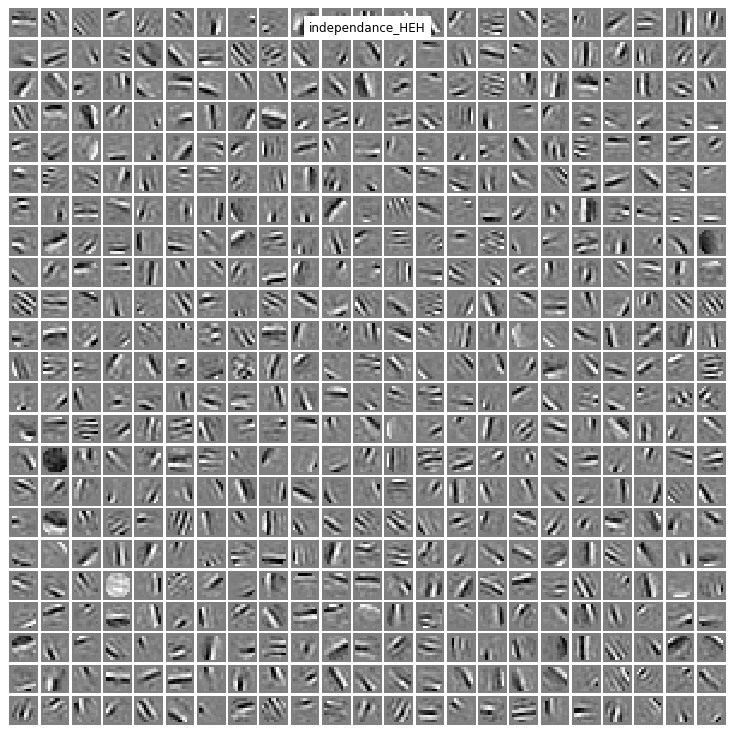

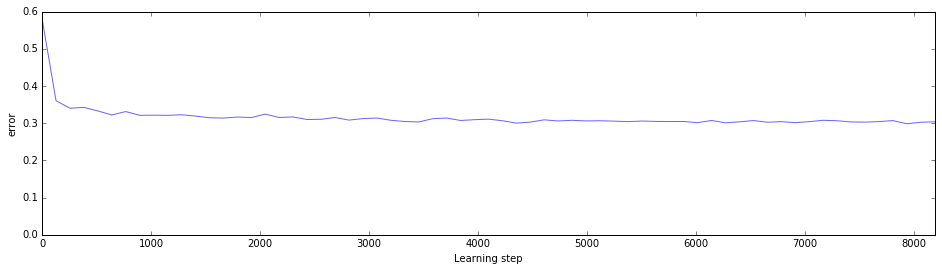

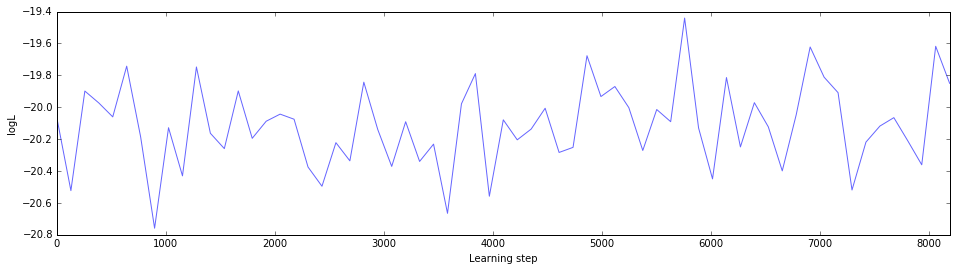

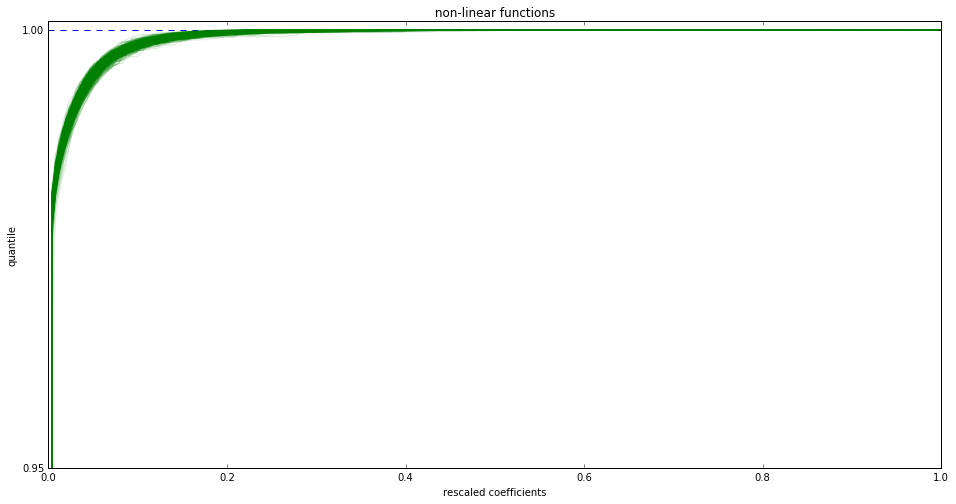

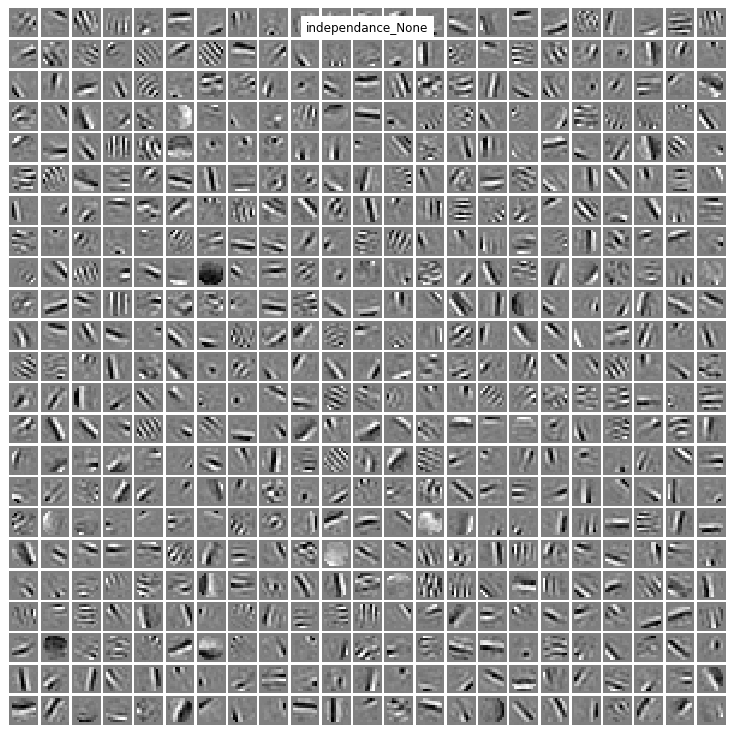

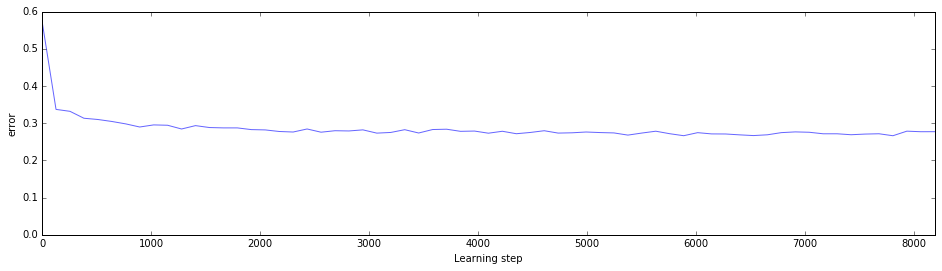

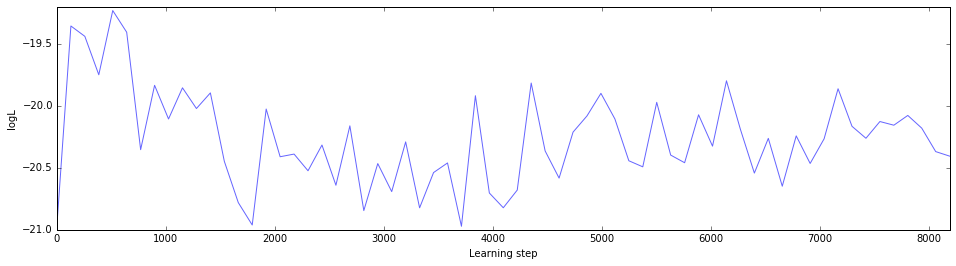

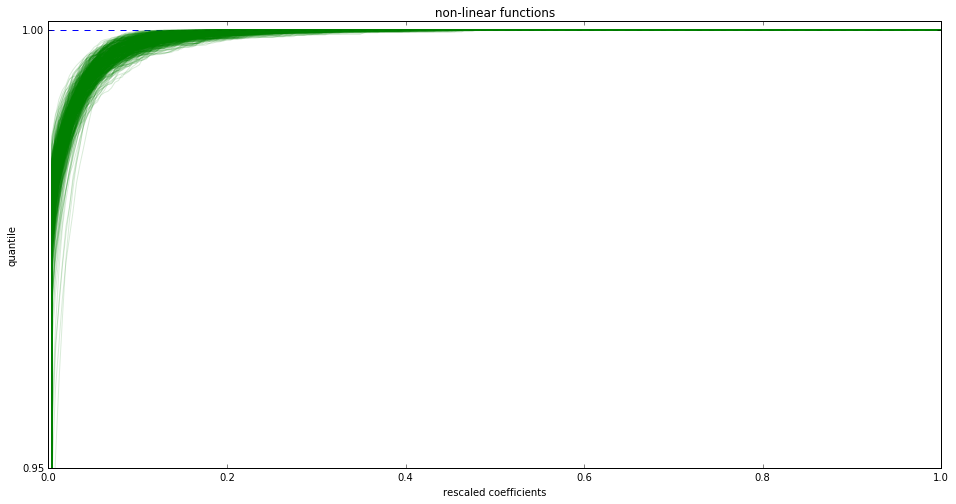

In [7]:
list_figures = ['show_dico', 'time_plot_error', 'time_plot_logL']

dico = {}
for homeo_method in homeo_methods:
    shl = SHL(homeo_method=homeo_method, **opts)
    dico[homeo_method] = shl.learn_dico(data=data, list_figures=list_figures, matname=tag + '_' + homeo_method)

    print('size of dictionary = (number of filters, size of imagelets) = ', dico[homeo_method].dictionary.shape)
    print('average of filters = ',  dico[homeo_method].dictionary.mean(axis=1).mean(), 
          '+/-',  dico[homeo_method].dictionary.mean(axis=1).std())
    SE = np.sqrt(np.sum(dico[homeo_method].dictionary**2, axis=1))
    print('average energy of filters = ', SE.mean(), '+/-', SE.std())

    if not dico[homeo_method].P_cum is None: 
        from shl_scripts.shl_tools import plot_P_cum
        fig, ax = plot_P_cum(dico[homeo_method].P_cum, verbose=False, alpha=.15);
        ax.set_ylim(0.95, 1.001)
        #ax.set_xmargin(0.);

## theory



Sum of non-zero coefficients 61644 ~= 61440
average non-zeros 116.52930056710775 ~= 116.14366729678639


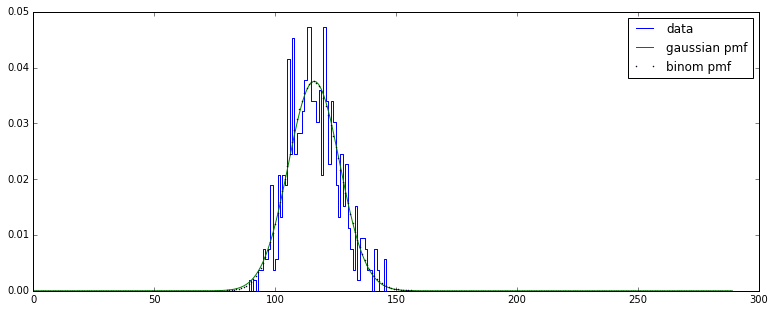

In [8]:
from scipy.stats import binom
# define the mean
rho = shl.l0_sparseness / shl.n_dictionary

# draw binomial samples
sparse_code_binary = np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho

# define the theoretical standard deviation
sd = np.sqrt(rho*(1-rho)*record_num_batches)

# the binomial probability is defined from 0 to record_num_batches \times shl.n_dictionary
# for visualization, we show the part around non-zero probabilities:
#record_num_batches_high = int(rho * record_num_batches + 15. * sd)
record_num_batches_high = int(2.5 * rho * record_num_batches)
bins = np.arange(record_num_batches_high)

print('Sum of non-zero coefficients', sparse_code_binary.sum(), '~=', shl.l0_sparseness*record_num_batches)
print('average non-zeros', np.count_nonzero(sparse_code_binary, axis=0).mean(), '~=', rho*record_num_batches)
fig, ax= plt.subplots(figsize=(13, 5))
smarts, edges = np.histogram(np.count_nonzero(sparse_code_binary, axis=0), density=True, bins=bins)
smarts /= smarts.sum()
ax.step(edges, np.hstack((smarts, 0)), where='pre', label='data');
#edges_mid = .5*( edges[1:] + edges[:-1] )
#print(rho, s, edges)
proba = np.exp(-.5 * (edges - rho*record_num_batches)**2 / sd**2)
proba /= proba.sum()
ax.plot(edges, proba, label='gaussian pmf');
proba_binom = binom.pmf(edges, record_num_batches, rho)
proba_binom /= proba_binom.sum()
ax.plot(edges, proba_binom, 'bo', ms=1, label='binom pmf')
ax.legend()

In [9]:
def get_logL(sparse_code):
    record_num_batches = sparse_code.shape[0]
    rho_hat = np.count_nonzero(sparse_code_binary, axis=0).mean()/record_num_batches
    #rho = shl.l0_sparseness / shl.n_dictionary
    sd = np.sqrt(rho_hat*(1-rho_hat)*record_num_batches)

    measures = np.count_nonzero(sparse_code, axis=0)

    # likelihood = 1 / np.sqrt(2*np.pi) / sd *  np.exp(-.5 * (measures - rho)**2 / sd**2)
    logL = -.5 * (measures - rho_hat*record_num_batches)**2 / sd**2
    logL -= np.log(np.sqrt(2*np.pi) * sd)
    #print(np.log(np.sum(np.exp(logL))), np.log(np.sqrt(2*np.pi) * sd))
    #logL -= np.log(np.sum(np.exp(logL)))
    return logL
    

In [10]:
rho = shl.l0_sparseness / shl.n_dictionary
sd = np.sqrt(rho*(1-rho)*record_num_batches)

for _ in range(10):
    sparse_code_binary = np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho
    logL = get_logL(sparse_code_binary)
    print ('log-likelihood for random sample=', logL.mean(), '+/-', logL.std())


log-likelihood for random sample= -3.8522855933274767 +/- 0.7433867663836642
log-likelihood for random sample= -3.7662851585585613 +/- 0.7171581203086959
log-likelihood for random sample= -3.7699526739633065 +/- 0.7221654255815952
log-likelihood for random sample= -3.7257017326816806 +/- 0.5985190442680215
log-likelihood for random sample= -3.779019614609411 +/- 0.7428732444679411
log-likelihood for random sample= -3.8099529153949465 +/- 0.7434762021852052
log-likelihood for random sample= -3.7383654854372814 +/- 0.693582133024381
log-likelihood for random sample= -3.8053010097936713 +/- 0.8066690222793448
log-likelihood for random sample= -3.7523664703557262 +/- 0.6208090432163167
log-likelihood for random sample= -3.789372186263566 +/- 0.6605136995943122


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [11]:
from shl_scripts.shl_tools import show_data
def print_stats(data, dictionary, sparse_code):
    print(42*'🐒')

    print('number of codes, size of codewords = ', sparse_code.shape)
    print('average of codewords = ', sparse_code.mean())
    print('average std of codewords = ', sparse_code.std())
    print('l0-sparseness of codewords = ', (sparse_code>0).mean(), ' ~= l0/M =', shl.l0_sparseness/shl.n_dictionary)
    print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())


    plt.matshow(sparse_code[:N_show, :])
    plt.show()
    fig, axs = show_data(data[:max_patches, :])
    plt.show()

    patches = sparse_code @ dictionary
    error = data - patches
    
    print('number of codes, size of reconstructed images = ', patches.shape)

    fig, axs = show_data(patches[:max_patches, :])
    plt.show()
    fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(patches[:max_patches, :])))
    plt.show()
    print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
    print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
    SD = np.sqrt(np.mean(data**2, axis=1))

    print('median energy of data = ', np.median(SD))
    print('average energy of data = ', SD.mean(), '+/-', SD.std())
    
    SE = np.sqrt(np.mean(error**2, axis=1))

    print('average energy of residual = ', SE.mean(), '+/-', SE.std())
    print('median energy of residual = ', np.median(SE))
    print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())
    
    return SD, SE

In [12]:
homeo_methods

['HEH', 'None']

🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (4096, 529)
average of codewords =  0.004114920554816883
average std of codewords =  0.04405645269478477
l0-sparseness of codewords =  0.028276930233931945  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.0012440674529306203


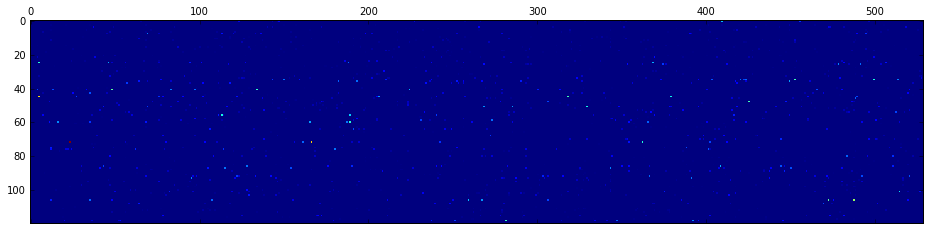

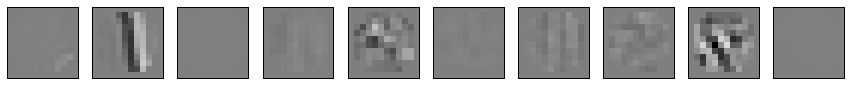

number of codes, size of reconstructed images =  (4096, 144)


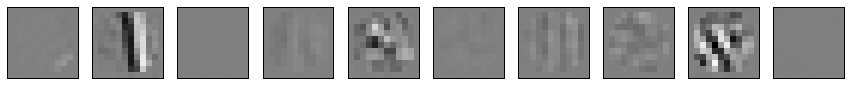

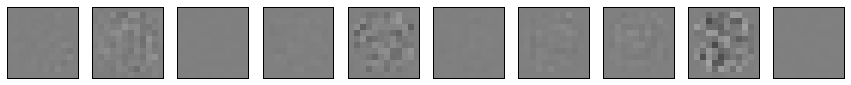

average of data patches =  9.671107629588464e-05 +/- 0.00790634147277896
average of residual patches =  -0.00017097339407649357 +/- 0.002664966741695752
median energy of data =  0.03157256849239622
average energy of data =  0.058366424955181254 +/- 0.0671468605348295
average energy of residual =  0.018133309293358157 +/- 0.02024584422372021
median energy of residual =  0.010667917979558527
average gain of coding =  3.678336125205459 +/- 1.4818449588634544
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (4096, 529)
average of codewords =  0.004080007827763664
average std of codewords =  0.04326993576625184
l0-sparseness of codewords =  0.02790633491847826  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.003588902776128507


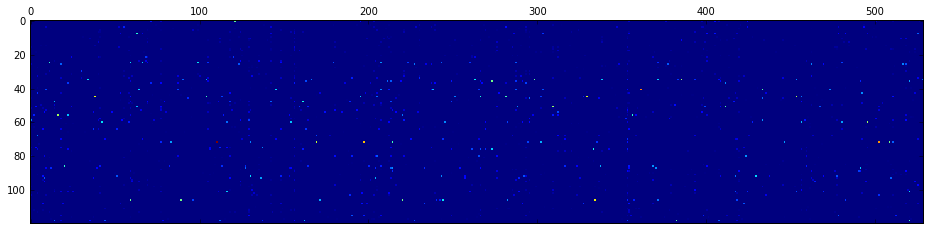

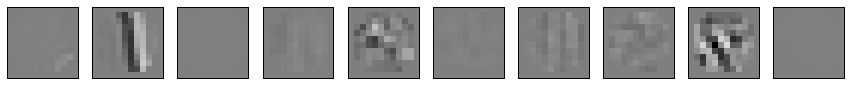

number of codes, size of reconstructed images =  (4096, 144)


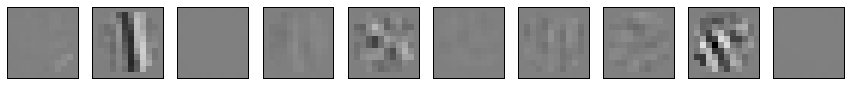

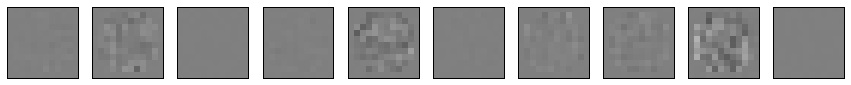

average of data patches =  9.671107629588464e-05 +/- 0.00790634147277896
average of residual patches =  -0.00027562528581020194 +/- 0.003923233513958334
median energy of data =  0.03157256849239622
average energy of data =  0.058366424955181254 +/- 0.0671468605348295
average energy of residual =  0.02180322089243767 +/- 0.023208305935981787
median energy of residual =  0.014996057957669687
average gain of coding =  3.173454536946512 +/- 1.6438686905832263


In [13]:
from shl_scripts.shl_encode import sparse_encode
sparse_code = {}
for homeo_method in homeo_methods:
    if dico[homeo_method].P_cum is None: 
        gain = np.ones(shl.n_dictionary)
    else:
        gain = None
    sparse_code[homeo_method] = sparse_encode(data[indx, :], dico[homeo_method].dictionary, 
                                 P_cum=dico[homeo_method].P_cum, l0_sparseness = shl.l0_sparseness, C=C, gain=gain)
    SD, SE = print_stats(data[indx, :], dico[homeo_method].dictionary, sparse_code[homeo_method])

In [14]:
sparse_code[homeo_method].shape

(4096, 529)

Average of non-zero coefficients 0.028276930233931945 ~= 0.02835538752362949
Mean of non-zero coefficients 115.82230623818525 ~= 116.14366729678639
Mean of non-zero coefficients 115.82230623818525 +/- 47.8527059674296
Median of non-zero coefficients 107.0
Average of non-zero coefficients 0.02790633491847826 ~= 0.02835538752362949
Mean of non-zero coefficients 114.30434782608695 ~= 116.14366729678639
Mean of non-zero coefficients 114.30434782608695 +/- 121.96029599677892
Median of non-zero coefficients 72.0


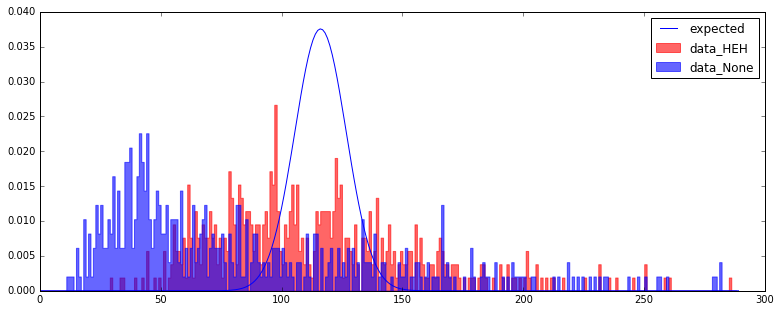

In [15]:
rho = shl.l0_sparseness / shl.n_dictionary
sd = np.sqrt(rho*(1-rho)*record_num_batches)

fig, ax= plt.subplots(figsize=(13, 5))
for homeo_method, color in zip(homeo_methods, ['r', 'b']):
    print('Average of non-zero coefficients', (sparse_code[homeo_method]>0).mean(), '~=', rho)
    n_i = np.count_nonzero(sparse_code[homeo_method], axis=0)
    print('Mean of non-zero coefficients', n_i.mean(), '~=', rho*record_num_batches)
    print('Mean of non-zero coefficients', n_i.mean(), '+/-', n_i.std())
    print('Median of non-zero coefficients', np.median(n_i))
    smarts, edges = np.histogram(n_i, density=True, bins=bins)
    smarts /= smarts.sum()
    # ax.step(edges, np.hstack((smarts, 0)), where='pre', label='data_' + homeo_method);
    ax.fill_between(edges[:-1], smarts, step='pre', label='data_' + homeo_method, alpha=.6, color=color);

proba = 1 / np.sqrt(2*np.pi) / sd *  np.exp(-.5 * (edges - rho*record_num_batches)**2 / sd**2)
#proba /= proba.sum()
ax.plot(edges, proba, label='expected')
ax.legend();

In [16]:
rho, sparse_code[homeo_method].mean(), homeo_methods

(0.02835538752362949, 0.004080007827763664, ['HEH', 'None'])

## measuring the distance to independance 

In [17]:
#fig, ax= plt.subplots(figsize=(13, 5))
for homeo_method in homeo_methods:
    logL = get_logL(sparse_code[homeo_method])
    print ('log-likelihood for homeo_method=', homeo_method, 'is', logL.mean(), '+/-', logL.std())
    #ax.vline(edges, proba, label=homeo_method)

logL = get_logL(np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho)
print ('log-likelihood for theory=', homeo_method, 'is', logL.mean(), '+/-', logL.std())
#for _ in range(10):
#    logL = get_logL(np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho)
#ax.plot(edges, proba, label='theory')
#ax.legend();

log-likelihood for homeo_method= HEH is -13.421792225030211 +/- 32.95682735222911
log-likelihood for homeo_method= None is -69.1567102407645 +/- 249.50829542607298
log-likelihood for theory= None is -3.824816069277525 +/- 0.765886335962241


## Version used

In [18]:
%load_ext version_information
%version_information numpy, shl_scripts, pandas

Software versions
Python 3.5.2 64bit [GCC 5.4.0 20160609]
IPython 6.2.1
OS Linux 4.13.0 32 generic x86_64 with Ubuntu 16.04 xenial
numpy 1.14.0
shl_scripts 20171221
pandas 0.22.0
Tue Feb 20 17:01:49 2018 CET